<a href="https://colab.research.google.com/github/naashonomics/genai_random/blob/main/Image2text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import pipeline
import matplotlib.pyplot as plt
import urllib
import numpy as np
from PIL import Image
import torch

In [3]:
# @title Model Selection  { display-mode: "form" }
model = "microsoft/git-base" #@param ["Salesforce/blip2-opt-2.7b", "microsoft/git-base"]

model_pipe = pipeline("image-to-text", model=model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Caption: a kitten playing with a toy


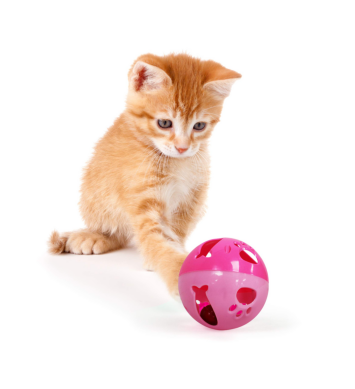

In [4]:
# @title Prediction  { display-mode: "form" }
image_path = 'https://m.media-amazon.com/images/I/71cXwgCUrYL.jpg' #@param {type:"string"}

if image_path.startswith('http'):
  img = np.array(Image.open(urllib.request.urlopen(image_path)))
else:
  img = plt.imread(image_path)

caption = model_pipe(image_path)[0]['generated_text']
print('Caption:', caption)

plt.axis('off')
plt.imshow(img)

In [7]:
!python3 -m pip install salesforce-lavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 26.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━

In [8]:
import lavis
from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam

In [9]:
# @title Setup Gradcam model {display-mode: "form"}
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "base", device=device, is_eval=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.78G/1.78G [00:22<00:00, 85.6MB/s]


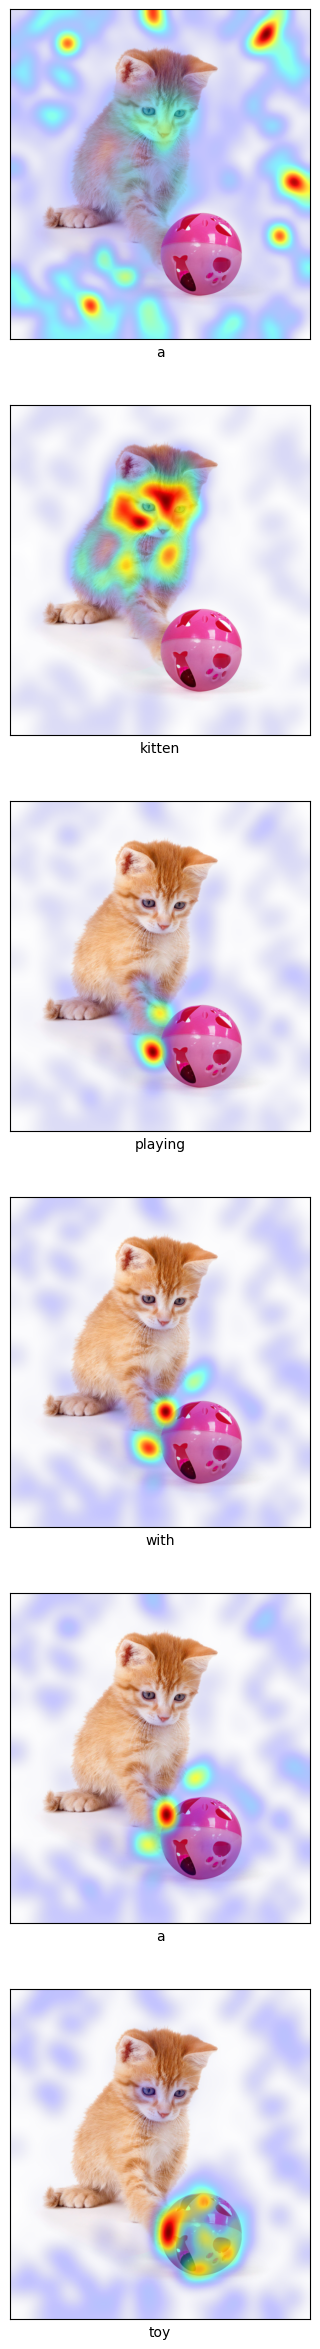

In [10]:
# @title Compute Gradcam  { display-mode: "form" }
def visualize_attention(img, full_caption):
    raw_image = Image.fromarray(img).convert('RGB')

    dst_w = 720
    w, h = raw_image.size
    scaling_factor = dst_w / w

    resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
    norm_img = np.float32(resized_img) / 255

    img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
    txt = text_processors["eval"](full_caption)

    txt_tokens = model.tokenizer(txt, return_tensors="pt").to(device)
    gradcam, _ = compute_gradcam(model, img, txt, txt_tokens, block_num=7)
    gradcam[0] = gradcam[0].numpy().astype(np.float32)

    num_image = len(txt_tokens.input_ids[0]) - 2
    fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

    gradcam_iter = iter(gradcam[0][2:-1])
    token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

    for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
        word = model.tokenizer.decode([token_id])
        gradcam_image = getAttMap(norm_img, gradcam, blur=True)
        gradcam_image = (gradcam_image * 255).astype(np.uint8)
        ax[i].imshow(gradcam_image)
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_xlabel(word)

visualize_attention(img, caption)